#Topic ประเทศไทยเราต้องการ ผลิตกระแสไฟฟ้าเพิ่มมากขึ้นจริง ๆ มั้ย# New Section

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.dates as mdates

In [ ]:
url = "https://docs.google.com/spreadsheets/d/1oMD7GTQ1RslgVAESNMMLA2J6njxn1OwG/export?format=xlsx"

In [ ]:
data = pd.read_excel(url, sheet_name="Master table")
df_peak = pd.read_excel(url, sheet_name="Elec_Peak_Gen")

In [ ]:
data['ID'] = pd.to_datetime(
    data['Year'].astype(str) + '-' + data['Date'],
    format='%Y-%b'
    )
# เวลาโชว์ format 2025-Jan แต่ยังเป็น datetime อยู่
data['Year-Month'] = data['ID'].dt.strftime('%Y-%b')
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Date'], format='%Y-%b').dt.strftime('%b').str.upper()
data["Year"] = data["Year"].astype(int)
data = data.rename(columns={"Date":"Month"}).sort_values(by="ID")
month_order = ["JAN","FEB","MAR","APR","MAY","JUN",
               "JUL","AUG","SEP","OCT","NOV","DEC"]
data['Month'] = pd.Categorical(
    data['Month'],
    categories=month_order,
    ordered=True
)


data["Quarter"] = data["ID"].dt.quarter
data["Quarter"] = "Q" + data["Quarter"].astype(str)
col = ['Year-Month','Year','Quarter','Month'] + [c for c in data.columns if c != 'Year-Month' and c != 'Year' and c !='Quarter' and c != 'Month']
data = data[col]
data = data.set_index('ID').sort_index()
data.to_csv("data.csv")

In [ ]:
df = data.copy()
df["Year-Month"] = pd.to_datetime(df["Year-Month"])
df = df.sort_values("Year-Month")

month_map = {'JAN':1,'FEB':2,'MAR':3,'APR':4,'MAY':5,'JUN':6,
             'JUL':7,'AUG':8,'SEP':9,'OCT':10,'NOV':11,'DEC':12}
if "Year-Month" not in df.columns:
    df["Month_Num"] = df["Date"].astype(str).str.upper().map(month_map)
    df["Year-Month"] = pd.to_datetime(
        df["Year"].astype(int).astype(str) + "-" +
        df["Month_Num"].astype(int).astype(str) + "-01",
        format="%Y-%m-%d", errors="coerce"
    )
# Convert Year-Month to datetime if not already
#df_norm = df_norm.copy()
df.index = pd.to_datetime(df.index, errors="coerce")


/tmp/ipython-input-3157686263.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Year-Month"] = pd.to_datetime(df["Year-Month"])


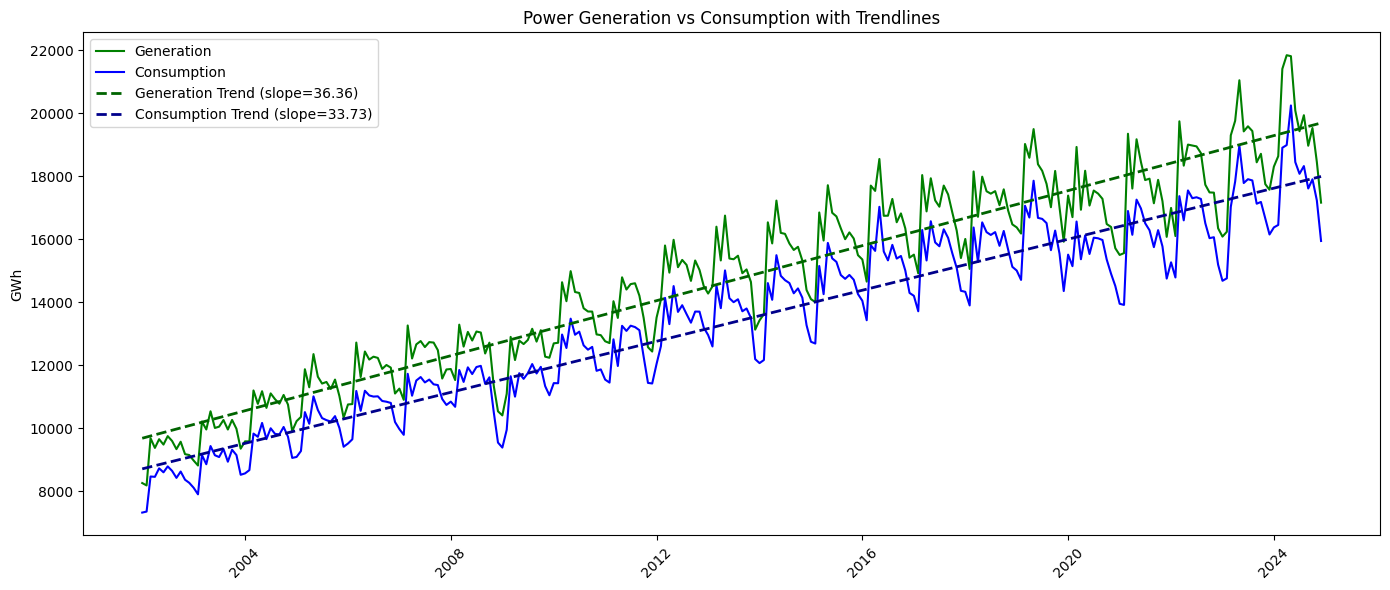

In [ ]:
x = np.arange(len(df))  # ใช้ index เป็นตัวเลขสำหรับ regression

# Fit linear regression
coeffs_gen = np.polyfit(x, df["POWER GENERATION (GWh)"], 1)
coeffs_cons = np.polyfit(x, df["Electrical consump Grand Total (GWh)"], 1)

trend_gen = np.poly1d(coeffs_gen)
trend_cons = np.poly1d(coeffs_cons)

plt.figure(figsize=(14,6))

# Plot actual data
plt.plot(df["Year-Month"], df["POWER GENERATION (GWh)"], label="Generation", color="green")
plt.plot(df["Year-Month"], df["Electrical consump Grand Total (GWh)"], label="Consumption", color="blue")

# Plot trend lines
plt.plot(df["Year-Month"], trend_gen(x), "--", color="darkgreen", linewidth=2, label=f"Generation Trend (slope={coeffs_gen[0]:.2f})")
plt.plot(df["Year-Month"], trend_cons(x), "--", color="darkblue", linewidth=2, label=f"Consumption Trend (slope={coeffs_cons[0]:.2f})")

plt.title("Power Generation vs Consumption with Trendlines")
plt.ylabel("GWh")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


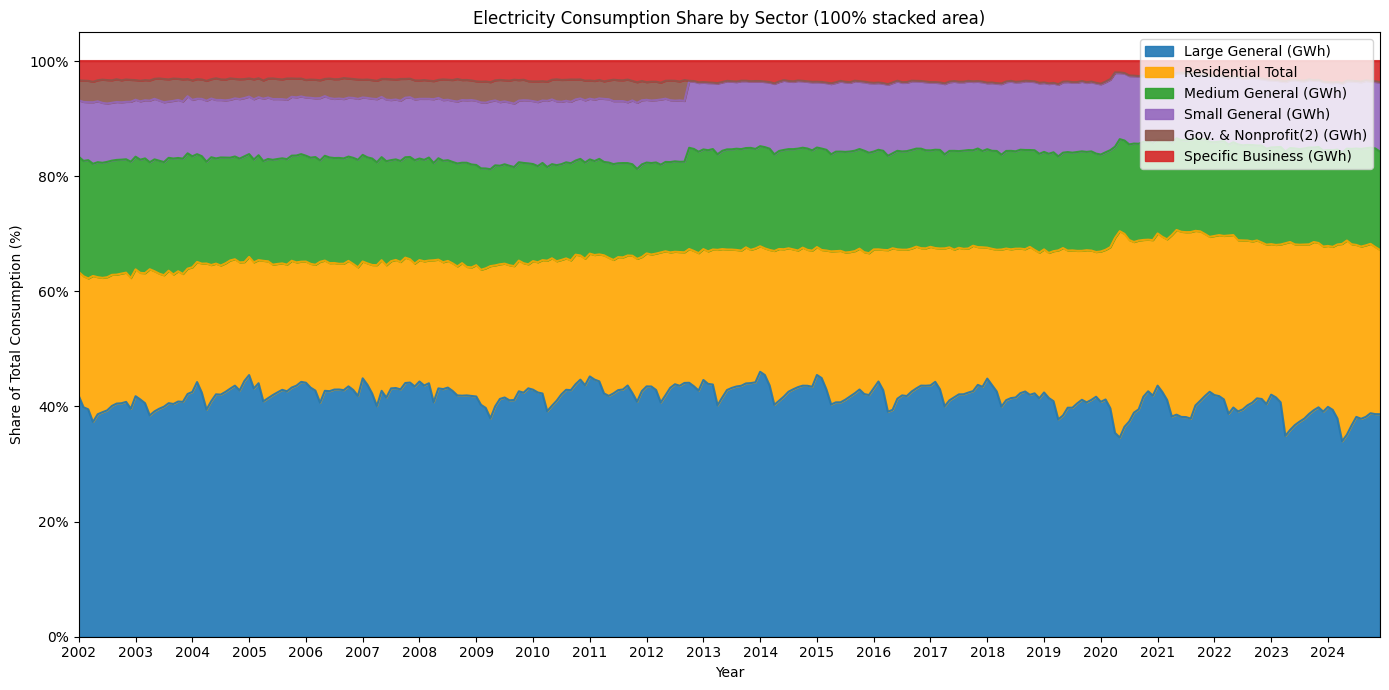

In [ ]:
# --- Select key sectors ---
cols = [
    "Large General (GWh)",
    "Residential Total",
    "Medium General (GWh)",
    "Small General (GWh)",
    "Gov. & Nonprofit(2) (GWh)",
    "Specific Business (GWh)"
]

# --- Prep dataframe ---
df_plot = df[["Year-Month"] + cols].copy()
# (optional but robust) ensure numeric
for c in cols:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")
df_plot = df_plot.set_index("Year-Month")

# --- Normalize to % (stacked to 100%) ---
df_norm = df_plot.div(df_plot.sum(axis=1), axis=0) * 100

# --- Colors (define BEFORE plotting) ---
custom_colors = {
    "Large General (GWh)": "#1f77b4",      # blue
    "Residential Total": "orange",         # orange
    "Medium General (GWh)": "#2ca02c",     # green
    "Small General (GWh)": "#9467bd",      # purple
    "Gov. & Nonprofit(2) (GWh)": "#8c564b",# brown
    "Specific Business (GWh)": "#d62728"   # red
}
color_list = [custom_colors[c] for c in df_norm.columns]


fig, ax = plt.subplots(figsize=(14,7))
df_norm.plot.area(
    stacked=True,
    color=[custom_colors[c] for c in df_norm.columns],
    alpha=0.9,
    ax=ax
)

ax.set_title("Electricity Consumption Share by Sector (100% stacked area)")
ax.set_ylabel("Share of Total Consumption (%)")
ax.set_xlabel("Year")

# Format y-axis as percentage with no decimals
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

# --- Force yearly ticks using the original df_norm.index ---
years = pd.period_range(df_norm.index.min(), df_norm.index.max(), freq="Y").to_timestamp()
ax.set_xticks(years)
ax.set_xticklabels([d.strftime("%Y") for d in years])
plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

ax.legend(loc="upper right")
ax.grid(False)
plt.tight_layout()
plt.show()

## **Hypothesis 1 อุณหภูมิ, ความมั่งคั่งทางเศรษฐกิจ, จำนวนประชากร, พฤติกรรมการใช้รถไฟฟ้า เป็นปัจจัยที่ส่งผลต่อการใช้งานไฟฟ้าหรือไม่**




### **1.1 อุณหภูมิส่งผลต่อการใช้งานไฟฟ้าหรือไม่**

/tmp/ipython-input-3197561139.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Year","Month"], as_index=False)["LF_frac"].mean()


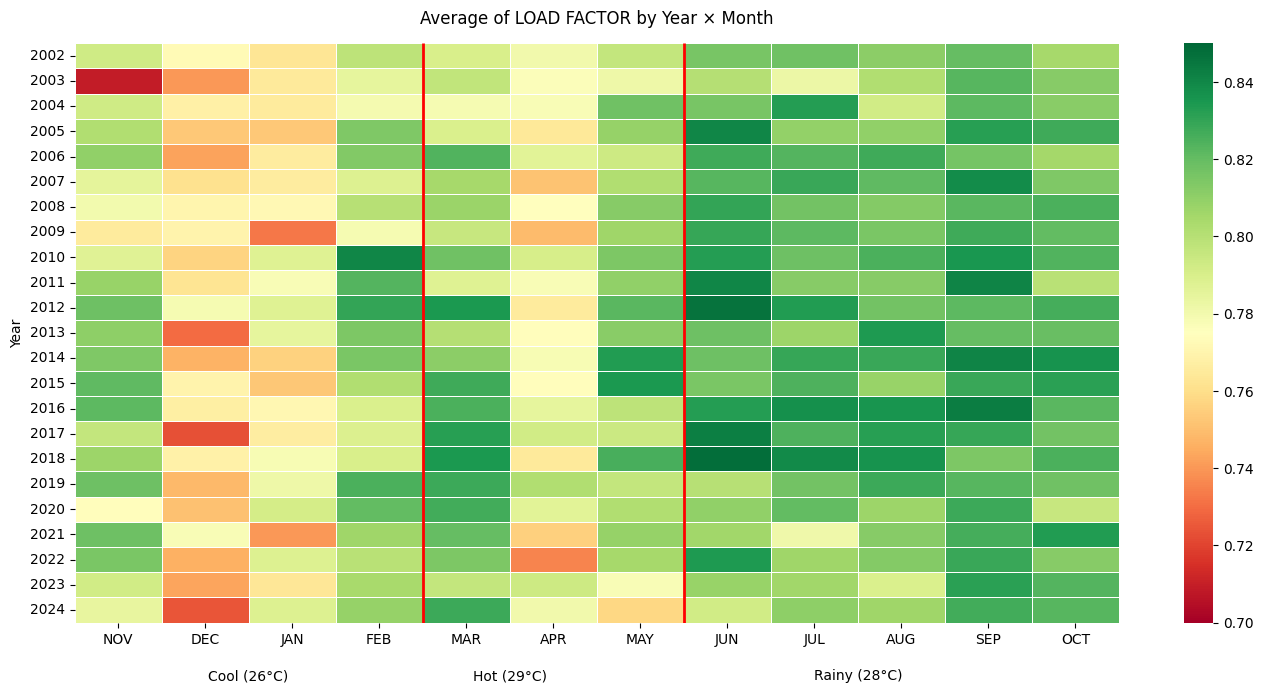

In [ ]:
# --- Prep as you already have ---
df["LOAD FACTOR (%)"] = pd.to_numeric(df["LOAD FACTOR (%)"], errors="coerce")
df["LF_frac"] = df["LOAD FACTOR (%)"] / (100 if df["LOAD FACTOR (%)"].mean() > 1 else 1)

month_order = ["NOV","DEC","JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT"]
df["Month"] = pd.Categorical(df["Month"].astype(str).str.upper(),
                             categories=month_order, ordered=True)

piv = (
    df.dropna(subset=["Year","Month","LF_frac"])
      .groupby(["Year","Month"], as_index=False)["LF_frac"].mean()
      .pivot(index="Year", columns="Month", values="LF_frac")
      .sort_index()
)

# --- Plot heatmap ---
plt.figure(figsize=(14, 7))
ax = sns.heatmap(
    piv,
    cmap="RdYlGn",
    vmin=0.70, vmax=0.85,
    annot=False,
    linewidths=0.4, linecolor="white",
    cbar=True
)

ax.set_title("Average of LOAD FACTOR by Year × Month", pad=14)
ax.set_xlabel("")
ax.set_ylabel("Year")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# ---------- Add seasonal separators & labels ----------
# Month index positions (cell boundaries) for separators:
# NOV(0) DEC(1) JAN(2) FEB(3) | MAR(4) APR(5) MAY(6) | JUN(7) JUL(8) AUG(9) SEP(10) OCT(11)
sep_positions = [4, 7]  # before MAR and before JUN

# draw vertical red lines
ymin, ymax = ax.get_ylim()  # note: heatmap inverts y-axis, but vlines respects these values
for x in sep_positions:
    ax.vlines(x, ymin, ymax, colors="red", linewidth=2)

# draw a red border rectangle
# from matplotlib.patches import Rectangle
# ax.add_patch(Rectangle((0, 0), 12, piv.shape[0],
#                        fill=False, edgecolor="red", linewidth=2))

# group labels at the bottom
# use axis transform so text sits just below the x-axis regardless of data limits
trans = ax.get_xaxis_transform()
ax.text(2.0, -0.08, "Cool (26°C)", ha="center", va="top", transform=trans, color="black")
ax.text(5.0, -0.08, "Hot (29°C)",  ha="center", va="top", transform=trans, color="black")
ax.text(9.0, -0.08, "Rainy (28°C)",ha="center", va="top", transform=trans, color="black")

# # optional: thin red baseline under labels to match the look
# ax.hlines(y=-0.005*(ymax - ymin), xmin=0, xmax=12, colors="red", linewidth=2, transform=ax.transData)

plt.tight_layout()
plt.show()


### **1.2 ปริมาณการผลิตไฟฟ้าสอดคล้องกับการเจริญเติบโตของเศรษฐกิจในประเทศหรือไม่**

/tmp/ipython-input-4134159572.py:11: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  gen_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["GEN_m_yoy%"].mean()
/tmp/ipython-input-4134159572.py:12: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  con_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["CON_m_yoy%"].mean()
/tmp/ipython-input-4134159572.py:15: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  gdp_q_sum = df.resample("Q-DEC", on="Year-Month")["GDP (Milion of Baht)"].sum(min_count=1)


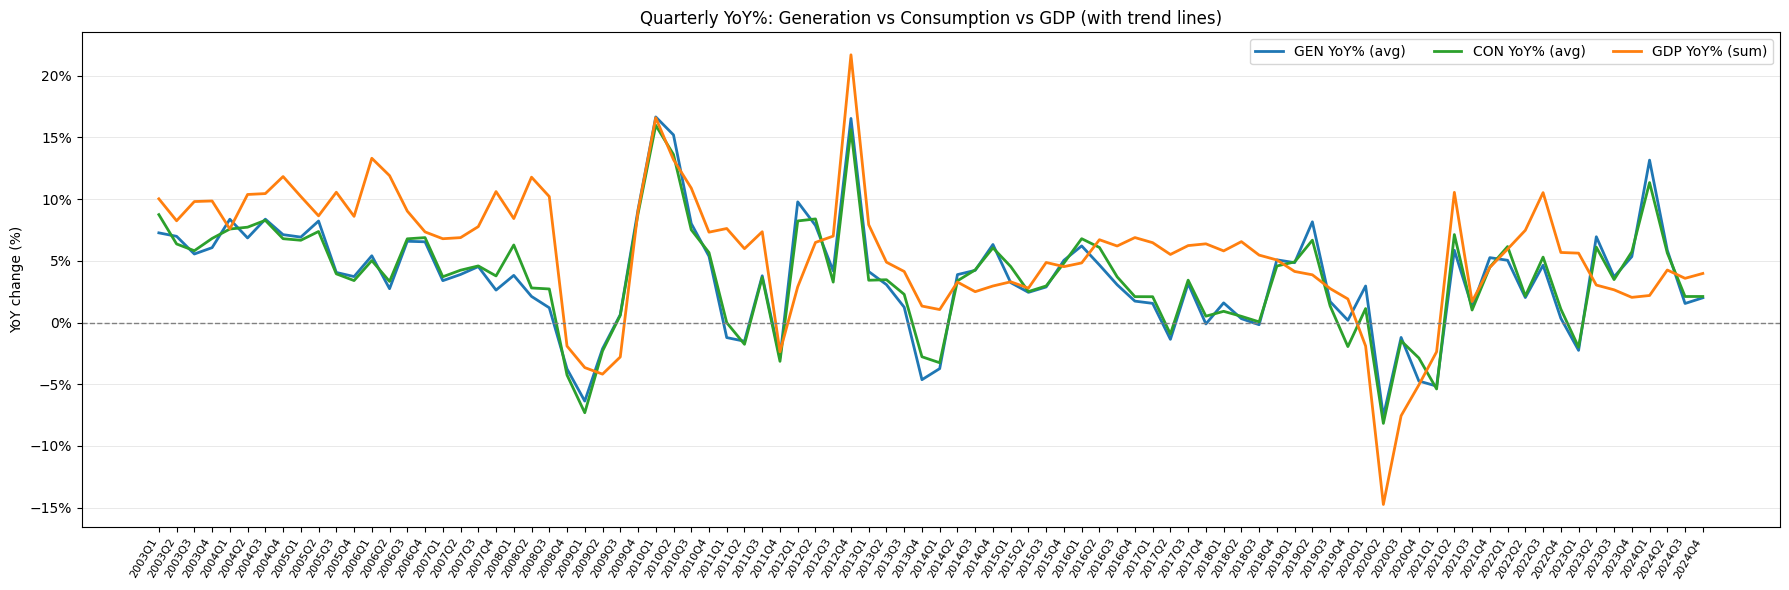

In [ ]:
# ---------------------------
# Step 2: Quarterly YoY% table
# ---------------------------

# 1) Compute MONTHLY YoY% (lag 12 months)
df["GEN_m_yoy%"] = df["POWER GENERATION (GWh)"].pct_change(12) * 100
df["CON_m_yoy%"] = df["Electrical consump Grand Total (GWh)"].pct_change(12) * 100

# 2) Aggregate to QUARTERLY
# GEN/CON → average of monthly YoY% in the quarter
gen_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["GEN_m_yoy%"].mean()
con_q_avg_yoy = df.resample("Q-DEC", on="Year-Month")["CON_m_yoy%"].mean()

# GDP → quarterly sum, then YoY% (vs 4 quarters earlier)
gdp_q_sum = df.resample("Q-DEC", on="Year-Month")["GDP (Milion of Baht)"].sum(min_count=1)
gdp_q_yoy = gdp_q_sum.pct_change(4) * 100

# 3) Combine into final table
calc_table = pd.DataFrame({
    "Year+Q": gen_q_avg_yoy.index.to_period("Q").astype(str),
    "Average of GEN_yoy%": gen_q_avg_yoy.values,
    "Sum of GDP_yoy%": gdp_q_yoy.values,
    "Average of Con_yoy%": con_q_avg_yoy.values
}).dropna().reset_index(drop=True)

# 4) Round for readability
calc_table = calc_table.round(6)

# print("\nQuarterly Calculation Table (YoY%):")
# print(calc_table.head(12))

plot_df = calc_table.copy()
x = np.arange(len(plot_df))   # numeric index for regression
labels = plot_df["Year+Q"].tolist()

fig, ax = plt.subplots(figsize=(18,6))

# --- Plot original lines ---
ax.plot(x, plot_df["Average of GEN_yoy%"], label="GEN YoY% (avg)", color="#1f77b4", lw=2)
ax.plot(x, plot_df["Average of Con_yoy%"], label="CON YoY% (avg)", color="#2ca02c", lw=2)
ax.plot(x, plot_df["Sum of GDP_yoy%"],     label="GDP YoY% (sum)", color="#ff7f0e", lw=2)

# # --- Add trend lines ---
# for col, color, name in [
#     ("Average of GEN_yoy%", "#1f77b4", "GEN Trend"),
#     ("Average of Con_yoy%", "#2ca02c", "CON Trend"),
#     ("Sum of GDP_yoy%", "#ff7f0e", "GDP Trend")
# ]:
#     y = plot_df[col].values
#     b1, b0 = np.polyfit(x, y, 1)       # linear regression
#     ax.plot(x, b1*x + b0, ls="--", lw=2, color=color, alpha=0.7, label=f"{name} (trend)")

# --- Formatting ---
ax.axhline(0, color="gray", ls="--", lw=1)
ax.set_title("Quarterly YoY%: Generation vs Consumption vs GDP (with trend lines)")
ax.set_ylabel("YoY change (%)")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

# Show every quarter label
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=60, ha="right", fontsize=8)

ax.grid(True, axis="y", lw=0.5, alpha=0.4)
ax.legend(loc="upper right", ncol=3)
plt.tight_layout()
plt.show()

# ===========================
# 5) Correlation heatmap (GEN, CON, GDP)
# ===========================
corr_df = plot_df[[
    "Average of GEN_yoy%",
    "Sum of GDP_yoy%",
    "Average of Con_yoy%"
]].rename(columns={
    "Average of GEN_yoy%": "Generate",
    "Sum of GDP_yoy%": "GDP",
    "Average of Con_yoy%": "Consumption"
})



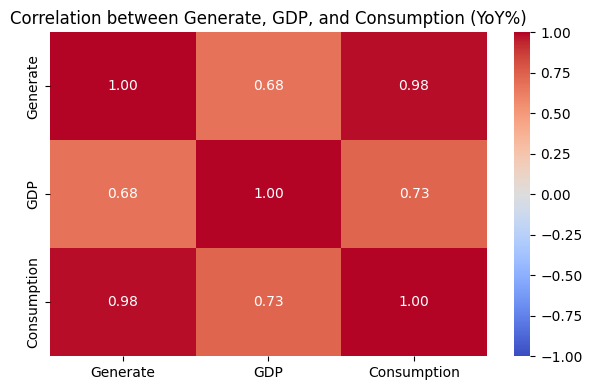

In [ ]:
# compute correlation
corr_matrix = corr_df.corr()

# plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation between Generate, GDP, and Consumption (YoY%)")
plt.tight_layout()
plt.show()


### **1.3 ประชากรในประเทศไทยส่งผลต่อปริมาณการใช้ไฟฟ้าหรือไม่**

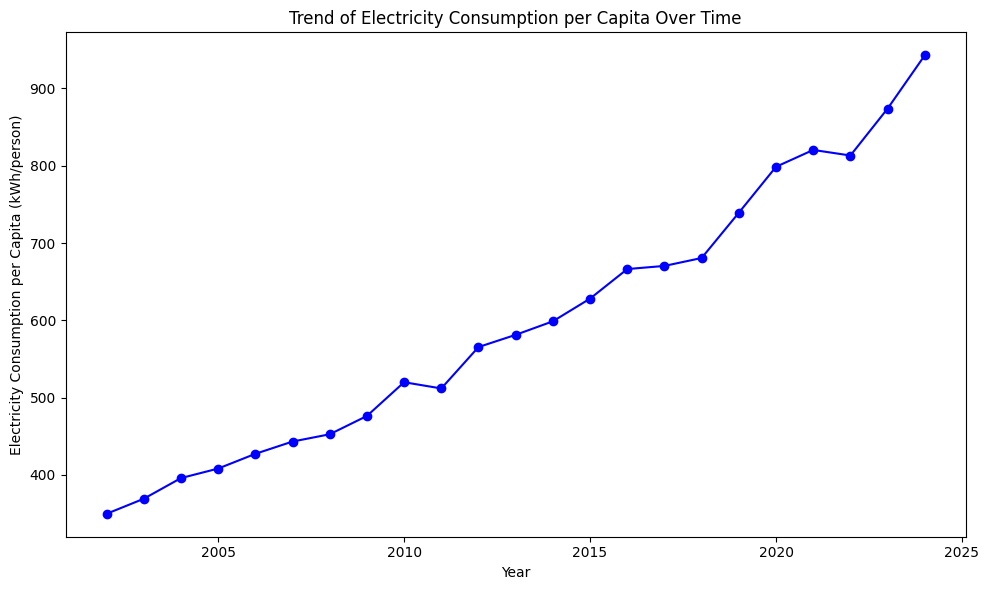

In [ ]:
Question3 = data.loc[:, ["Year-Month","Year", "Residential Total", "Total Population (People)"]]
Question3["Yearly_Resident_Comsump"]  = Question3.groupby(Question3["Year"])["Residential Total"].cumsum()
Question3 = Question3.reset_index()
Question3.set_index('Year', inplace=True)
Question3 = Question3.loc[:, ["Yearly_Resident_Comsump", "Total Population (People)"]].dropna(subset=["Total Population (People)"])
Question3.reset_index(inplace=True)

Question3["Yearly_Resident_Comsump_kWh"] = Question3["Yearly_Resident_Comsump"] * 1e6  # 1 GWh = 1e6 kWh

# คำนวณไฟฟ้าต่อหัว
Question3["Electricity_per_capita_kWh"] = Question3["Yearly_Resident_Comsump_kWh"] / Question3["Total Population (People)"]

# Plot แนวโน้มไฟฟ้าต่อหัว
plt.figure(figsize=(10,6))
plt.plot(Question3["Year"], Question3["Electricity_per_capita_kWh"], marker="o", linestyle="-", color="blue")
plt.xlabel("Year")
plt.ylabel("Electricity Consumption per Capita (kWh/person)")
plt.title("Trend of Electricity Consumption per Capita Over Time")
plt.tight_layout()
plt.show()

### **1.4 การเข้ามาของรถไฟฟ้า EV มีผลทำให้ปริมาณความต้องการใช้ไฟฟ้าในครัวเรือนเพิ่มขึ้นหรือไม่**


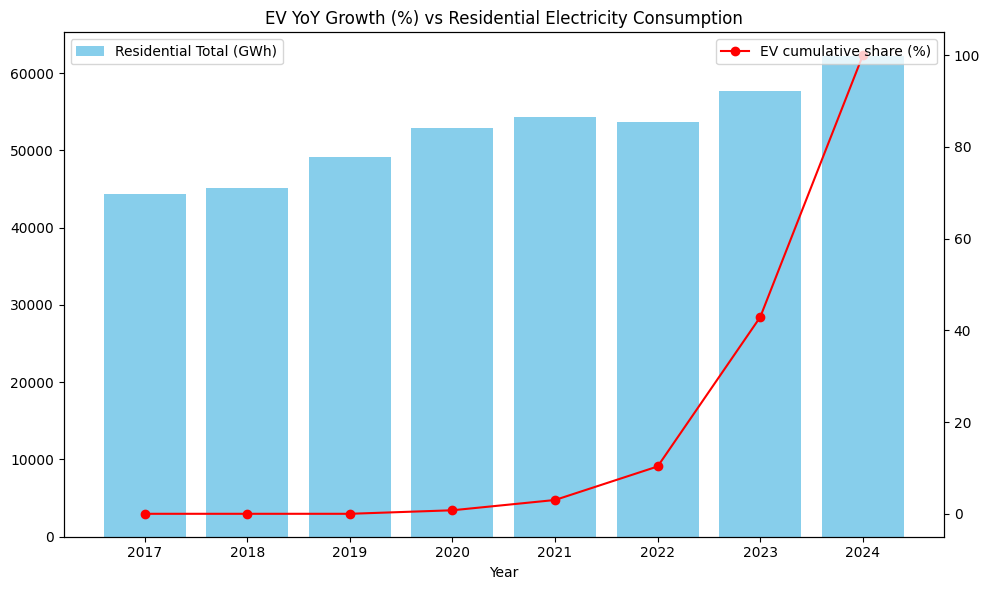

In [ ]:
# --- 1) Build yearly table ---
Question4 = data.loc[:, ["Year-Month","Year","Residential Total", "EV Car (EA)"]].sort_values(by="ID").reset_index()
Question4["EV_car_accum"] = Question4["EV Car (EA)"].cumsum()
# Question4

# --- 0) เตรียมลำดับเวลาให้ถูกก่อน ---
# ถ้าไม่มีคอลัมน์ 'ID' ให้ sort ด้วย 'Year-Month' แทน
Question4 = data.loc[:, ["Year-Month","Year","Residential Total","EV Car (EA)"]].copy()
Question4 = Question4.sort_values("Year-Month").reset_index(drop=True)

# ยอดสะสมรายเดือนของ EV
Question4["EV_car_accum"] = Question4["EV Car (EA)"].cumsum()

# --- 1) สรุปรายปี (ไฟฟ้าใช้ sum, รถ EV สะสมใช้ค่าปลายปี = last) ---
Question4 = (
    Question4[["Year", "Residential Total", "EV_car_accum"]]
    .groupby("Year", as_index=True)
    .agg({
        "Residential Total": "sum",
        "EV_car_accum": "last"
    })
    .sort_index()
    .tail(8)          # เอา 8 ปีล่าสุด (รวมปีล่าสุด)
    .fillna(0)
)

# ===== เลือก 1 ใน 3 เมตริกตามความหมายที่ต้องการ =====

# (A) EV YoY growth (%) ของยอดสะสม (เหมาะกับชื่อ "Growth")
Question4["EV YoY growth (%)"] = Question4["EV_car_accum"].pct_change().fillna(0) * 100

# (B) EV cumulative share (%) = สัดส่วน "สะสมตั้งแต่ต้นจนถึงปีนั้น" เทียบทั้งชุด (0→100%)
Question4["EV cumulative share (%)"] = Question4["EV_car_accum"].cumsum() / Question4["EV_car_accum"].sum() * 100

# (C) EV portion on year (%) = “ส่วนแบ่งที่ปีนั้นเพิ่มเข้าไป” เทียบกับยอดสะสมสุดท้าย
ev_net_add = Question4["EV_car_accum"].diff().fillna(Question4["EV_car_accum"])
Question4["EV portion on year (%)"] = (ev_net_add / Question4["EV_car_accum"].iloc[-1]) * 100

# --- 3) Plot (ตัวอย่างใช้แบบ A: YoY growth %) ---
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# แท่งฟ้า = การใช้ไฟฟ้าภาคบ้านเรือน
ax1.bar(
    Question4.index,
    Question4["Residential Total"],
    label="Residential Total (GWh)",
    color="skyblue"
)

ax1.set_xlabel("Year")

# เส้นแดง = EV YoY growth (%)
ax2 = ax1.twinx()
ax2.plot(
    Question4.index,
    Question4["EV cumulative share (%)"],
    marker="o",
    label="EV cumulative share (%)",
    color="red"
)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.title("EV YoY Growth (%) vs Residential Electricity Consumption")
plt.tight_layout()
plt.show()

## **Hypothesis 2.  แนวโน้มการผลิตไฟฟ้ามีความสอดคล้องต่อความต้องการหรือไม่**

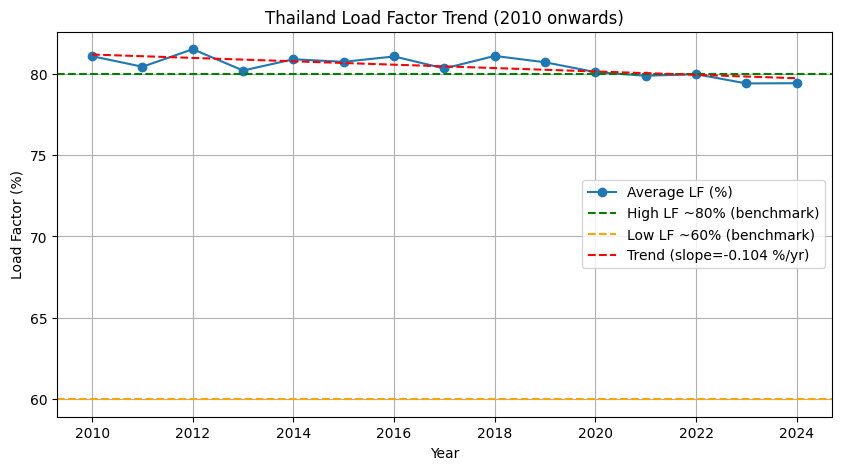

In [ ]:
# ทำความสะอาดค่า LF
df_lf = data.copy()
df_lf["LOAD FACTOR (%)"] = pd.to_numeric(df_lf["LOAD FACTOR (%)"], errors="coerce")

# กรองเฉพาะปี >= 2010
lf_year = df_lf[df_lf["Year"] >= 2010].groupby("Year", as_index=False).agg({
    "LOAD FACTOR (%)": "mean"
})

# Plot
plt.figure(figsize=(10,5))
plt.plot(lf_year["Year"], lf_year["LOAD FACTOR (%)"], marker='o', label="Average LF (%)")

# Benchmarks
plt.axhline(80, color='green', linestyle='--', label="High LF ~80% (benchmark)")
plt.axhline(60, color='orange', linestyle='--', label="Low LF ~60% (benchmark)")

# Trend line
x = lf_year["Year"].values.astype(float)
y = lf_year["LOAD FACTOR (%)"].values.astype(float)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label=f"Trend (slope={z[0]:.3f} %/yr)")

# # คำนวณ R² (optional)
# yhat = p(x)
# ss_res = np.sum((y - yhat)**2)
# ss_tot = np.sum((y - y.mean())**2)
# r2 = 1 - ss_res/ss_tot
# plt.title(f"Thailand Load Factor Trend (2010 onwards) (R²={r2:.3f})")

plt.title("Thailand Load Factor Trend (2010 onwards)")
plt.xlabel("Year")
plt.ylabel("Load Factor (%)")
plt.grid(True)
plt.legend()
plt.show()

🔹 1. Load Factor (LF) Trend (2010–2024)

ค่า LF เฉลี่ยอยู่ราว ๆ 79–82% ตลอดช่วง 2010–2024

Slope = –0.104 %/yr → หมายความว่า LF ของไทย ลดลงเล็กน้อยทุกปี (ระบบมีการผลิตสำรองมากขึ้นเมื่อเทียบกับการใช้จริง)

ค่าที่อยู่เหนือ benchmark 80% (เส้นเขียว) เกือบทุกปี → แสดงว่าระบบไฟไทย “ประสิทธิภาพสูง” เมื่อเทียบกับมาตรฐานสากล (IEA/EIA มองว่าค่า 60–80% เป็นปกติ)

แต่การที่แนวโน้มลดลง (แม้เพียงเล็กน้อย) บ่งบอกว่า การลงทุนโรงไฟฟ้าใหม่อาจเร็วกว่า demand growth → ทำให้ oversupply เพิ่มขึ้น


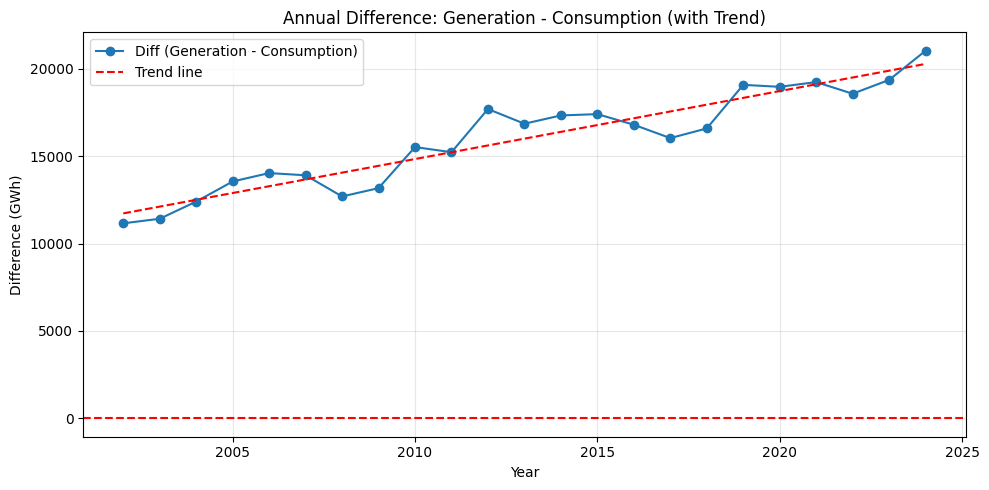

In [ ]:
df = data.copy()
# --- Ensure numeric columns ---
df["POWER GENERATION (GWh)"] = pd.to_numeric(df["POWER GENERATION (GWh)"], errors="coerce")
df["Electrical consump Grand Total (GWh)"] = pd.to_numeric(df["Electrical consump Grand Total (GWh)"], errors="coerce")

# Diff at row level (safe even if not in original data)
df["Diff (GWh)"] = df["POWER GENERATION (GWh)"] - df["Electrical consump Grand Total (GWh)"]

# --- Aggregate to annual ---
annual = (
    df.dropna(subset=["Year"])
      .groupby("Year", as_index=False)
      .agg({
          "POWER GENERATION (GWh)": "sum",
          "Electrical consump Grand Total (GWh)": "sum",
          "Diff (GWh)": "sum"
      })
      .sort_values("Year")
)

# Margin (%), guarding divide-by-zero
den = annual["Electrical consump Grand Total (GWh)"].replace(0, pd.NA)
annual["Margin (%)"] = annual["Diff (GWh)"] / den * 100

# --- Plot ---
plt.figure(figsize=(10,5))
plt.plot(annual["Year"], annual["Diff (GWh)"], marker='o', label="Diff (Generation - Consumption)")
plt.axhline(0, color='red', linestyle='--')

# Trend line (label only "Trend line")
x = annual["Year"].values.astype(float)
y = annual["Diff (GWh)"].values.astype(float)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(annual["Year"], p(x), "r--", label="Trend line")

plt.title("Annual Difference: Generation - Consumption (with Trend)")
plt.xlabel("Year")
plt.ylabel("Difference (GWh)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Oversupply (Generation – Consumption) Trend (2002–2024)

ส่วนต่าง เพิ่มขึ้นต่อเนื่อง จาก ~11,000 GWh (2002) → เกิน 20,000 GWh (2024)

เส้น trend (สีแดง) ชี้ชัดว่า oversupply ของไทย โตขึ้นเรื่อย ๆ

Oversupply สูงขึ้นหมายความว่า:

ไทย มีกำลังผลิตสำรอง (reserve margin) สูงมาก → ระบบมั่นคง ปลอด blackout

แต่ก็สะท้อนว่า ลงทุนเกินความจำเป็น → ต้นทุนค่าไฟ (ค่า Ft) อาจสูงขึ้นเพราะต้องจ่ายค่าความพร้อมจ่าย (Availability Payment) ให้โรงไฟฟ้าที่ไม่ได้เดินเครื่องเต็มที่

สรุป Insight
🔹 3. การเชื่อมโยง 2 กราฟ

LF ลดลง (เล็กน้อย) + Oversupply เพิ่มขึ้น → เป็นสัญญาณชัดเจนว่า ไฟฟ้าสำรองในระบบมากเกินความต้องการจริง

ในเชิงวิศวกรรมระบบไฟ → ดีต่อความมั่นคง (reliability) แต่ ไม่คุ้มค่าในเศรษฐศาสตร์พลังงาน

การมี oversupply สูงต่อเนื่องสะท้อนนโยบายการลงทุนโรงไฟฟ้าแบบ “build ahead of demand” ของไทย

📌 Insight สุดท้าย

Positive: ไทยมีระบบไฟที่มั่นคงมาก, blackout น้อย, รองรับการเติบโต demand ได้

Negative: Oversupply สูง → ค่าไฟไม่ถูกลงเพราะมี fixed cost จากโรงไฟฟ้า, LF ลดลงทำให้ใช้ประโยชน์โรงไฟฟ้าไม่เต็มที่

Policy implication: ควรชะลอการลงทุนโรงไฟฟ้าใหม่, หันไปเพิ่ม demand response, energy efficiency, renewable integration เพื่อลด oversupply


## **Hypothesis 3 การผลิตไฟฟ้าในประเทศไทย มีสัดส่วนการผลิตจากภาครัฐและภาคเอกชน เป็นอัตราส่วนเป็นอย่างไร**

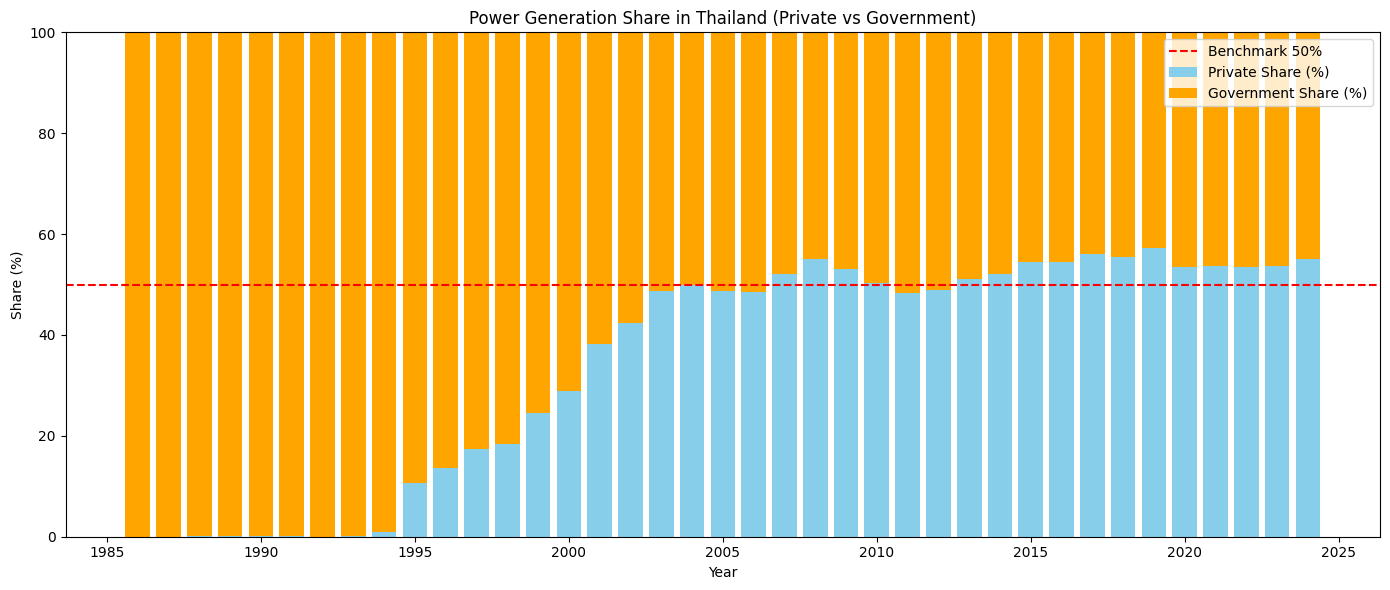

In [ ]:
Gen = pd.read_excel(url, sheet_name="Elec_Gen")
# เตรียมข้อมูล
df = Gen[["Year", "EGAT TOTAL", "Private Power Plant "]].dropna()
df = df.groupby("Year").sum().reset_index()

# คำนวณสัดส่วนเป็น %
df["Gov Share (%)"] = df["EGAT TOTAL"] / (df["EGAT TOTAL"] + df["Private Power Plant "]) * 100
df["Private Share (%)"] = df["Private Power Plant "] / (df["EGAT TOTAL"] + df["Private Power Plant "]) * 100

# Plot stacked bar (สลับให้ Private อยู่ล่าง, Gov อยู่บน)
plt.figure(figsize=(14,6))
plt.bar(df["Year"], df["Private Share (%)"], label="Private Share (%)", color="skyblue")
plt.bar(df["Year"], df["Gov Share (%)"], bottom=df["Private Share (%)"], label="Government Share (%)", color="orange")

# เส้น benchmark 50%
plt.axhline(50, color="red", linestyle="--", linewidth=1.5, label="Benchmark 50%")

plt.title("Power Generation Share in Thailand (Private vs Government)")
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()